**извлечение признаков из текста на естественном языке**

word2vec : skip-gram


Евгений Борисов <esborisov@sevsu.ru>

https://arxiv.org/pdf/1301.3781.pdf

https://www.youtube.com/watch?v=aZ5se_SW81c

---

In [1]:
# import sys
import re
import gzip
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# # загружаем предварительно очищенный текст
# with gzip.open('../data/text.txt.gz','rt',encoding='utf-8') as f: text = f.read()

In [3]:
# загружаем текст
with gzip.open('../data/dostoevsky-besy-p2.txt.gz','rt',encoding='utf-8') as f: 
    text = [ s.strip() for s in re.split(r'[\n.?!]',f.read()) if s.strip() ]

In [4]:
len(text)

6200

In [5]:
# убираем заголовок
text = text[7:]

---

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

In [7]:
# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е',] # замена ё для унификации
       ,[r'[^а-я ]+',' '] # оставляем только буквы и пробел
       ,[r'^- *',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [8]:
text = list(map(string_normalizer,text))

In [9]:
text[:5]

['теперь когда уже все прошло и я пишу хронику мы уже знаем в чем дело но тогда мы еще ничего не знали и естественно что нам представлялись странными разные вещи',
 'по крайней мере мы со степаном трофимовичем в первое время заперлись и с испугом наблюдали издали',
 'я то кой куда еще выходил и по прежнему приносил ему разные вести без чего он и пробыть не мог',
 'нечего и говорить что по городу пошли самые разнообразные слухи то есть насчет пощечины обморока лизаветы николаевны и прочего случившегося в то воскресенье',
 'но удивительно нам было то через кого это все могло так скоро и точно выйти наружу']

In [10]:
# разрезаем текст на слова
text = [ [ w.strip() for w in s.split() if w.strip() ] for s in text ]

In [11]:
# text[:2]

In [12]:
context_deep = 2 # глубина контекста

In [13]:
# удаляем короткие словосочетания
text = [ s for s in text if len(s) > context_deep*2 ]
len(text)

4568

In [14]:
text

[['теперь',
  'когда',
  'уже',
  'все',
  'прошло',
  'и',
  'я',
  'пишу',
  'хронику',
  'мы',
  'уже',
  'знаем',
  'в',
  'чем',
  'дело',
  'но',
  'тогда',
  'мы',
  'еще',
  'ничего',
  'не',
  'знали',
  'и',
  'естественно',
  'что',
  'нам',
  'представлялись',
  'странными',
  'разные',
  'вещи'],
 ['по',
  'крайней',
  'мере',
  'мы',
  'со',
  'степаном',
  'трофимовичем',
  'в',
  'первое',
  'время',
  'заперлись',
  'и',
  'с',
  'испугом',
  'наблюдали',
  'издали'],
 ['я',
  'то',
  'кой',
  'куда',
  'еще',
  'выходил',
  'и',
  'по',
  'прежнему',
  'приносил',
  'ему',
  'разные',
  'вести',
  'без',
  'чего',
  'он',
  'и',
  'пробыть',
  'не',
  'мог'],
 ['нечего',
  'и',
  'говорить',
  'что',
  'по',
  'городу',
  'пошли',
  'самые',
  'разнообразные',
  'слухи',
  'то',
  'есть',
  'насчет',
  'пощечины',
  'обморока',
  'лизаветы',
  'николаевны',
  'и',
  'прочего',
  'случившегося',
  'в',
  'то',
  'воскресенье'],
 ['но',
  'удивительно',
  'нам',
  'было

---

In [15]:
# ограничиваем количество примеров, чтобы поместиться в память
n_samples = 100

i_samples = np.random.permutation(len(text))[:n_samples]

text = [ text[i] for i in i_samples ]

---

In [16]:
# заменяем слова в тексте их номерами в словаре
words = sorted(set(sum(text,[]))) # словарь из текста
vocab =  { w:i for i,w in enumerate(words) }
code = [ [ vocab[w] for w in s ] for s in text ]

In [17]:
n_words = len(words) # количество слов в словаре
print( "размер словаря: %i слов" % n_words )

размер словаря: 884 слов


In [18]:
# [ контекст, слово, контекст]
def pack_history(s,cd=context_deep):
    return [ [ s[i-cd:i], s[i], s[i+1:i+cd+1] ] for i in range(cd,len(s)-cd) ] 

In [19]:
context = sum( [ pack_history(s,cd=context_deep) for s in code ], [] )

In [20]:
W = [ c[1] for c in context ] # коды слов
C = [ c[0]+c[2] for c in context ] # коды контекста слов

In [21]:
assert len(C) == len(W)

In [22]:
n_words,len(W)

(884, 1213)

In [23]:
# # ограничиваем количество примеров, чтобы поместиться в память

# n_samples = 15000

# i_samples = np.random.permutation(len(W))[:n_samples]
# W = [ W[i] for i in i_samples ]
# C = [ C[i] for i in i_samples ]

---

In [24]:
len(W), len(C)

(1213, 1213)

---

In [25]:
# # унитарное кодирование слов (one-hot-encoding)
E = np.eye(n_words,dtype=np.int8)

Wbin = np.vstack([ E[c] for c in W ])
Wbin.shape

(1213, 884)

In [26]:
Cbin = np.vstack([ np.vstack([ E[c] for c in Ci ])[np.newaxis,:] for Ci in C ]) 
Cbin.shape

(1213, 4, 884)

---

In [27]:
# ф-ция активации скрытого слоя - линейная
# def act(s): return s

# ф-ция активации выходного слоя
def softmax(s): 
    e = np.exp(s)
    return e/e.sum(axis=1).reshape(s.shape[0],1)

In [28]:
def w2v_step(W,Vi,Vo):
    H = W.dot(Vi) # значения скрытого слоя
    U = H.dot(Vo) # состояния выходного слоя
    O = softmax(U) # выход сети
    return H,U,O


Функция потери

$$E = \left| \sum\limits_i\log\left( \sum\limits_k \exp(U_{ik}) \right) - \sum\limits_i\sum\limits_k\sum\limits_j (U_{ik} * Q_{ijk}) \right| $$


$U_{ik}$ состояние k-того нейрона выходного слоя для слова $i$     
$Q_{ij}$ слово $j$ контекста слова $i$   
где ∗ - операция поэлементного умножения векторов

In [29]:
def w2v_loss(U,C):
    n,cws,v = C.shape 
    # количество примеров
    # размер окна контекста   
    # количество слов в словаре

    Us = np.log( np.exp(U).sum(axis=1) ).sum()

    Uo = 0.0
    for i in range(cws): # для всех слов контекста
        Ci = C[:,i,:].reshape([n,v]) # набор слов контекста i
        Uo += (U*Ci).sum() # значения выходного слоя для слов x контекста i

    return np.abs(Us-Uo)/n

In [30]:
def w2v_grad(C,W,H,O,Vo):
    n,cws,v = C.shape
        # количество примеров
        # размер окна контекста   
        # количество слов в словаре

    gVi = gVo = 0.0 

    for i in range(cws):
        Ci = C[:,i,:].reshape([n,v]) # слово i контекста
        D = O - Ci # ошибка на слове контекста i
        gVo += D.T.dot(H).T
        gVi += W.T.dot(D).dot(Vo.T)

    return gVi,gVo

---

In [31]:
def w2v_weigth_norm(v,w):
    nn = np.linalg.norm( np.hstack([ v.flatten(), w.flatten() ]) )
    #nn = np.abs( np.hstack([ v.flatten(), w.flatten() ]) ).max()
    return (v/nn,w/nn) if nn!=0.0 else (v,w)

---

In [32]:
n = Wbin.shape[1] # количество слов в словаре
k = 30 # размер скрытого слоя H

Vi = np.random.normal(scale=0.01,size=(n,k))
Vo = np.random.normal(scale=0.01,size=(k,n))

In [33]:
%%time

a = 0.91 # скорость обучения

er = [1e10]

n_steps = 100

for i in range(n_steps):
    H,U,O = w2v_step(Wbin,Vi,Vo) # вычисляем состояния слоёв и выход
    er.append(w2v_loss(U,Cbin)) # вычисляем ошибку
    print(i+1, er[-1])
    if er[-1]>er[-2]: 
        Vi, Vo = Vi_old, Vo_old
        break
        
    gVi, gVo = w2v_grad(Cbin,Wbin,H,O,Vo) # вычисляем градиент ф-ции потери
    gVi,gVo = w2v_weigth_norm(gVi,gVo) # нормируем значения градиента
    
    Vi_old, Vo_old =  Vi, Vo # сохраняем старые веса
    
    Vi,Vo = Vi-a*gVi, Vo-a*gVo # корректируем веса

1 6.7844391285676435
2 6.780390623532221
3 6.768014578191285
4 6.738786673190575
5 6.691009825201269
6 6.6240763436867
7 6.538364158708368
8 6.43635015542632
9 6.327559397101143
10 6.226362305099101
11 6.097706805511852
12 5.985277259546963
13 5.8424339716879725
14 5.7281981467949485
15 5.576219793141755
16 5.462666343213907
17 5.302927728546308
18 5.188740348605849
19 5.019493097014822
20 4.914381480742221
21 4.732739338638033
22 4.655685572258892
23 4.458867777060217
24 4.414373297533831
25 4.2068714103421945
26 4.176002552631431
27 3.963592607899402
28 3.9498265558007053
29 3.7328814916539548
30 3.7316828608376706
31 3.511936113334533
32 3.5266036718585907
CPU times: user 1min 21s, sys: 46.2 ms, total: 1min 21s
Wall time: 1min 21s


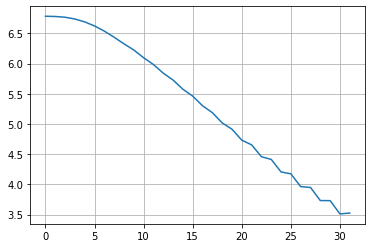

In [34]:
er=er[1:]
plt.plot(er)
plt.grid()
plt.show()

---

In [35]:
from sklearn.metrics.pairwise import pairwise_distances

In [36]:
D = pairwise_distances(Vi) # матрица расстояний
R = np.argsort(D) # номера слов в порядке увеличения расстояния

In [37]:
vocab = { i:w for i,w in enumerate(words) } # нумеруем слов в словаре

nn = np.random.permutation(len(words))[:20] # выбираем случайно N слов

# для выбранных слов печатаем близкие по w2v
{ vocab[i] : [ vocab[j] for j in  R[i,1:3]  ] for i in nn }

{'свидетелей': ['ну', 'настасья'],
 'тем': ['прискорбием', 'да'],
 'кредитками': ['двадцать', 'недоразумение'],
 'впрочем': ['лембку', 'злобы'],
 'время': ['начал', 'кружок'],
 'тебе': ['болел', 'денег'],
 'мире': ['помириться', 'другой'],
 'никого': ['убивать', 'шестнадцати'],
 'выстрелил': ['да', 'этою'],
 'прошу': ['помириться', 'ума'],
 'нашему': ['капитана', 'приходилось'],
 'себя': ['домика', 'поручик'],
 'через': ['малейшей', 'глухой'],
 'испуганный': ['руки', 'генерала'],
 'даю': ['раскачка', 'степановича'],
 'учителя': ['резвости', 'энергически'],
 'переулок': ['глухой', 'пил'],
 'вас': ['никто', 'вовсе'],
 'отвечая': ['ставрогин', 'коляске'],
 'толкаченкой': ['сперва', 'михайловна']}